In [1]:
import pandas as pd
import numpy as np
from math import erf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime as dt
import os,sys
import plotly.graph_objects as go
from plotly.subplots import make_subplots

%matplotlib inline
NUM_ITER = 10000
DAY_OF_SIM = dt.today() # dt.strptime(open("datefile.txt",'r').read()[:-1], '%d-%m-%Y') # 

In [2]:
republican_red = "#cf1313"
democratic_blue = "#116dc2"
other_grey = "#8a8a8a"
republican_red_alphaed = "rgba(207, 19, 19, 0.2)"
democratic_blue_alphaed = "rgba(17, 109, 194, 0.2)"
other_grey_alphaed = "rgba(138, 138, 138,0.2)"

color_mapper = {"Kamala Harris":democratic_blue,"Harris":democratic_blue,"Donald Trump":republican_red,"Trump":republican_red,"Others":other_grey,"Other":other_grey}
color_mapper_alphaed = {"Kamala Harris":democratic_blue_alphaed,"Harris":democratic_blue_alphaed,"Donald Trump":republican_red_alphaed,"Trump":republican_red_alphaed,"Others":other_grey_alphaed,"Other":other_grey_alphaed}

In [3]:
df = pd.read_csv("../1976-2020-president.csv") # Read in the election results in each state going back to 1976.

In [4]:
STARTYEAR = 0 #YEAR WHEN WE START INTERPRETING THE DATA
ELECTIONYEAR = 2024 # YEAR WE WANT TO PREDICT
df = df[(STARTYEAR <= df['year']) & (df['year']<ELECTIONYEAR)] # SLICE THE DATA FOR ABOVE


In [5]:
df['party_simplified'] = df['party_simplified'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else '3RDPARTY') # COMPRESS ALL THIRD PARTIES INTO ONE VALUE

df_grouped = df.groupby(['year', 'state_po', 'party_simplified'], as_index=False).agg({'candidatevotes': 'sum'}) # 

state_votes = df_grouped.pivot_table(index='state_po', columns=['party_simplified','year'], values='candidatevotes', fill_value=0) # GET THE STATE VOTES BY PARTY BY YEAR


In [6]:
total_votes = state_votes.sum().groupby(level='year').sum()
total_share = state_votes.sum() / state_votes.sum().index.get_level_values('year').map(total_votes) # CONVERT TO VOTESHARE

In [7]:
def predict(t,X,weights=None): # LINEAR REGRESSION MODEL
    model = LinearRegression()
    model.fit(t.reshape(-1, 1), X, sample_weight=weights)
    m = model.coef_[0]
    b = model.intercept_

    Xhats = m*t + b
    Xpred = m*ELECTIONYEAR + b
    Xvar = np.sum((X-Xhats)**2) / (len(X) - 2) * 1.75

    return Xpred, Xhats, Xvar

In [8]:
diffs = lambda x: x[1:] - x[:-1]

In [9]:
prior_diffs = {}
for i,the_state_vote in state_votes.iterrows():
    state_share = the_state_vote / the_state_vote.index.get_level_values('year').map(the_state_vote.groupby(level='year').sum()) # Convert the raw votes to percentages of the total vote in that state
    state_diff = state_share - total_share # Get the shift compared to the national share of the vote

    t = the_state_vote["DEMOCRAT"].index.values # Election years included in the model
    # tweights = np.arccos(1 - 2* ((t - t[0]) / (t - t[0])[-1])) /np.pi
    tweights = (t-t[0])**2

    other_diff_ = state_diff["3RDPARTY"].values
    other_diff_pred, other_diff_hats, other_diff_var = predict(t,other_diff_,tweights)
    other_diff_pred_ci = 1.96 * np.sqrt(other_diff_var)



    harris_diff_ = state_diff["DEMOCRAT"].values
    harris_diff_pred, harris_diff_hats, harris_diff_var = predict(t,harris_diff_,tweights)
    harris_diff_pred_ci = 1.96 * np.sqrt(harris_diff_var)

    trump_diff_ = state_diff["REPUBLICAN"].values
    trump_diff_pred, trump_diff_hats, trump_diff_var = predict(t,trump_diff_,tweights)
    trump_diff_pred_ci = 1.96 * np.sqrt(trump_diff_var)

    if i=="AZ":
        scatters=[]
        regressions=[]
        predictions=[]
        year_range=np.append(t, ELECTIONYEAR)

        candidate_diffs = [harris_diff_,trump_diff_,other_diff_]
        candidate_diff_hats=[harris_diff_hats,trump_diff_hats,other_diff_hats,]
        candidate_piff_preds=[harris_diff_pred,trump_diff_pred,other_diff_pred]
        candidate_cis=[harris_diff_pred_ci,trump_diff_pred_ci,other_diff_pred_ci]
        for i,candidate in enumerate(["Harris","Trump","Other"]):
            previous_scatter = go.Scatter(
                x=t,
                y=candidate_diffs[i],
                mode='markers',
                marker=dict(color=color_mapper[candidate],size=6),
                name='Other Scatter'
            )
            regression_line = go.Scatter(
                x=year_range,
                y=np.append(candidate_diff_hats[i], candidate_piff_preds[i]),
                mode='lines',
                line=dict(color=color_mapper[candidate]),
                name='Other Line'
            )

            trace_other_pred = go.Scatter(
                x=[ELECTIONYEAR],
                y=[candidate_piff_preds[i]],
                mode='markers',
                marker=dict(color=color_mapper[candidate], symbol='star',size=6),
                name='Other Prediction'
            )

            confidence_interval = go.Scatter(
                x=np.concatenate([year_range, year_range[::-1]]),
                y=np.concatenate([np.append(candidate_diff_hats[i], candidate_piff_preds[i]) + candidate_cis[i],(np.append(candidate_diff_hats[i], candidate_piff_preds[i]) - candidate_cis[i])[::-1]]),
                fill='toself',
                fillcolor=color_mapper_alphaed[candidate],
                line=dict(color='rgba(255, 255, 255, 0)'),  # No outline
                hoverinfo="skip",
                showlegend=False,
                name='Confidence Interval'
            )
            scatters.append(previous_scatter)
            regressions.append(regression_line)
            regressions.append(confidence_interval)
            predictions.append(trace_other_pred)
        print(harris_diff_pred)
        print(harris_diff_var)
        fig = go.Figure(data=scatters)
        fig.update_yaxes(range=[-0.15, 0.15],tickvals=[-0.15,-0.075,0,0.075,0.15],ticktext=["-15%","-7.5%","0%","7.5%","15%"])
        fig.update_layout(showlegend=False,dragmode=False,paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',margin={"r":0,"t":0,"l":0,"b":0})
        # fig.write_html(f"../docs/assets/AZ_evolve_scatter.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})
    
        fig = go.Figure(data=scatters+regressions)
        fig.update_yaxes(range=[-0.15, 0.15],tickvals=[-0.15,-0.075,0,0.075,0.15],ticktext=["-15%","-7.5%","0%","7.5%","15%"])
        fig.update_layout(showlegend=False,dragmode=False,paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',margin={"r":0,"t":0,"l":0,"b":0})
        # fig.write_html(f"../docs/assets/AZ_evolve_regression.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

        fig = go.Figure(data=scatters+regressions+predictions)
        fig.update_yaxes(range=[-0.15, 0.15],tickvals=[-0.15,-0.075,0,0.075,0.15],ticktext=["-15%","-7.5%","0%","7.5%","15%"])
        fig.update_layout(showlegend=False,dragmode=False,paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',margin={"r":0,"t":0,"l":0,"b":0})
        # fig.write_html(f"../docs/assets/AZ_evolve.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

    prior_diffs[the_state_vote.name] = {
        "other_diff":other_diff_pred,
        "other_var":other_diff_var,
        "harris_diff" :harris_diff_pred,
        "harris_var": harris_diff_var,
        "trump_diff": trump_diff_pred,
        "trump_var":trump_diff_var,    }
prior_diffs = pd.DataFrame(data=prior_diffs).T

-0.026251332243724335
0.0011393461175338898


In [10]:
national_vals = pd.read_csv("../polling_averages/National.csv",index_col='date')
todays_nat_polls = national_vals.loc[DAY_OF_SIM.strftime('%Y-%m-%d')]
state_mapper = pd.read_csv("../state_mapper.csv",index_col='state').to_dict()['code']

poll_other = todays_nat_polls["other_mean"]
poll_dem = todays_nat_polls["harris_mean"]
poll_rep = todays_nat_polls["trump_mean"]

post_preds = prior_diffs[['other_diff','harris_diff','trump_diff']].copy()
post_preds['other_diff'] += poll_other
post_preds['harris_diff'] += poll_dem
post_preds['trump_diff'] += poll_rep
post_preds.rename({'other_diff':'other_vote','harris_diff':'harris_vote','trump_diff':'trump_vote'},axis=1,inplace=True)


post_vars = prior_diffs[['other_var','harris_var','trump_var']].copy()
post_vars['other_var'] = post_vars['other_var']*post_preds['other_vote'] + todays_nat_polls["other_var"]
post_vars['trump_var'] = post_vars['trump_var'] + todays_nat_polls["trump_var"]
post_vars['harris_var'] = post_vars['harris_var'] + todays_nat_polls["harris_var"]


for state_avgs in os.listdir("../polling_averages"):
    if state_avgs[:-4] in state_mapper.keys():
        state_avgs_polls = pd.read_csv(f"../polling_averages/{state_avgs}",index_col='date')
        if state_avgs_polls.shape[0]==0:
            continue
        todays_state_polls = state_avgs_polls.loc[DAY_OF_SIM.strftime('%Y-%m-%d')] # 

    
        pre_poll_preds = post_preds.loc[state_mapper[state_avgs[:-4]]][["harris_vote","trump_vote","other_vote"]].copy().values
        pre_poll_vars = post_vars.loc[state_mapper[state_avgs[:-4]]][["harris_var","trump_var","other_var"]].copy().values

        pollmeans = todays_state_polls[["harris_mean","trump_mean","other_mean"]].values
        pollvars = todays_state_polls[["harris_var","trump_var","other_var"]].values

        post_poll_preds = (pre_poll_preds/pre_poll_vars + pollmeans/pollvars) / (1/pre_poll_vars + 1/pollvars)
        post_poll_vars = 1 / (1/pre_poll_vars + 1/pollvars)

        post_preds.loc[state_mapper[state_avgs[:-4]],'harris_vote'] = post_poll_preds[0]
        post_preds.loc[state_mapper[state_avgs[:-4]],'trump_vote'] = post_poll_preds[1]
        post_preds.loc[state_mapper[state_avgs[:-4]],'other_vote'] = post_poll_preds[2]

        post_vars.loc[state_mapper[state_avgs[:-4]],'harris_var'] = post_poll_vars[0]
        post_vars.loc[state_mapper[state_avgs[:-4]],'trump_var'] = post_poll_vars[1]
        post_vars.loc[state_mapper[state_avgs[:-4]],'other_var'] = post_poll_vars[2]



In [11]:
# Assume 0.5% random walk each day. Move the variance depending on the number of days remaining.
post_vars = post_vars + post_preds.values*((dt.strptime("2024-11-05",'%Y-%m-%d') - DAY_OF_SIM).days * 0.005**2 +0.003**2)

In [12]:
electoralvotes = {
    "AL":9,
    "AK":3,
    "AZ":11,
    "AR":6,
    "CA":54,
    "CO":10,
    "CT":7,
    "DC":3,
    "DE":3,
    "FL":30,
    "GA":16,
    "HI":4,
    "ID":4,
    "IL":19,
    "IN":11,
    "IA":6,
    "KS":6,
    "KY":8,
    "LA":8,
    "ME":4,
    "MD":10,
    "MA":11,
    "MI":15,
    "MN":10,
    "MS":6,
    "MO":10,
    "MT":4,
    "NE":5,
    "NV":6,
    "NH":4,
    "NJ":14,
    "NM":5,
    "NY":28,
    "NC":16,
    "ND":3,
    "OH":17,
    "OK":7,
    "OR":8,
    "PA":19,
    "RI":4,
    "SC":9,
    "SD":3,
    "TN":11,
    "TX":40,
    "UT":6,
    "VT":3,
    "VA":13,
    "WA":12,
    "WV":4,
    "WI":10,
    "WY":3}	


In [13]:
def to_cov(row,column):
    return row * np.sqrt(column.loc[row.name]) * np.sqrt(column)

In [14]:
correlation_factor = 0.5 # How correlated do we expect the previous correlations to predict the next correlations. Defaults to 0.5
trump_cov = state_votes['REPUBLICAN'].T.corr()
trump_cov = np.eye(trump_cov.shape[0])*(1-correlation_factor) + trump_cov*correlation_factor
trump_cov = trump_cov.apply(lambda row: to_cov(row,post_vars['trump_var']))


harris_cov = state_votes['DEMOCRAT'].T.corr()
harris_cov = np.eye(harris_cov.shape[0])*(1-correlation_factor) + harris_cov*correlation_factor
harris_cov = harris_cov.apply(lambda row: to_cov(row,post_vars['harris_var']))

oth_cov = state_votes['3RDPARTY'].T.corr()
oth_cov = np.eye(oth_cov.shape[0])*(1-correlation_factor) + oth_cov*correlation_factor
oth_cov = oth_cov.apply(lambda row: to_cov(row,post_vars['other_var']))

In [15]:
outputs = [] # SIMULATE ALL THE ELECTION RESULTS
for _ in range(NUM_ITER):
    election = pd.DataFrame(data = [np.clip(np.random.multivariate_normal(post_preds["trump_vote"],trump_cov),0,1),
                                    np.clip(np.random.multivariate_normal(post_preds["harris_vote"],harris_cov),0,1),
                                    np.clip(np.random.multivariate_normal(post_preds["other_vote"],oth_cov),0,1)
                            ], columns=trump_cov.columns,index=["trump_share","harris_share","oth_share"]).T
    
    harris_popular_vote = np.average(election['harris_share'],weights=state_votes.T.loc[(slice(None), ELECTIONYEAR-4), :].droplevel('year').sum())
    trump_popular_vote = np.average(election['trump_share'],weights=state_votes.T.loc[(slice(None), ELECTIONYEAR-4), :].droplevel('year').sum())
    oth_popular_vote = np.average(election['oth_share'],weights=state_votes.T.loc[(slice(None), ELECTIONYEAR-4), :].droplevel('year').sum())
    
    election['margin']=election["harris_share"] - election["trump_share"]
    election.sort_values(by='margin',ascending=False,inplace=True)

    election['winner']=["Harris"if res else "Trump" for res in election['margin']>0 ]

    election["Cummulative Trump EV"] = 0
    election["Cummulative Harris EV"] = 0



    harris_ev = 0
    trump_ev = 0
    other_ev = 0


    for state_name, result in election.iterrows():
        if result['winner']=="Harris":
            harris_ev += electoralvotes[state_name]
            election.loc[state_name,"Cummulative Harris EV"] = harris_ev

    election.sort_values(by='margin',ascending=True,inplace=True)
    for state_name, result in election.iterrows():
        if result['winner']=="Trump":
            trump_ev += electoralvotes[state_name]
            election.loc[state_name,"Cummulative Trump EV"] = trump_ev

    # Check if Electoral Vote Tie
    if (election[["Cummulative Harris EV","Cummulative Trump EV"]]==269).any().all():
        tipping_point_state = election[(election[["Cummulative Harris EV","Cummulative Trump EV"]]==269).any(axis=1)]['margin'].abs().idxmin()
    else:
        tipping_point_state = election[(election[["Cummulative Harris EV","Cummulative Trump EV"]]>= 270).any(axis=1)][["Cummulative Harris EV","Cummulative Trump EV"]].sum(axis=1).idxmin()
 


    output_df = election[["trump_share","harris_share","oth_share","winner"]]
    output = {
        "df":output_df,
        "facts":{
            "harris_popular_vote":harris_popular_vote,
            "trump_popular_vote":trump_popular_vote,
            "oth_popular_vote":oth_popular_vote,
            "tipping_point_state":tipping_point_state,
            "harris_ev":harris_ev
        }
    }
    outputs.append(output)

In [16]:
combined_df = pd.concat([output['df'] for output in outputs],axis=0)
median_df = combined_df[["trump_share",	"harris_share","oth_share"]].groupby(level=0).median()

In [17]:
def ensure_harris(counts):
    if "Harris" not in counts:
        counts["Harris"] = 0
    return counts
state_probs = combined_df.groupby(combined_df.index)["winner"].apply(lambda x: x.value_counts())
state_probs = state_probs.groupby(level=0).apply(ensure_harris)
state_probs = state_probs.reset_index(level=1, drop=True).unstack(fill_value=0).drop('',axis=1)

In [18]:
model_outputs = {}
for i,row in median_df.iterrows():
    p_harris_win = state_probs.loc[i,"Harris"] / state_probs.loc[i].sum()
    harris_margin_median = row["harris_share"] - row["trump_share"]


    model_outputs[i] = {
        "Probability Harris Win":p_harris_win,
        "Median Harris Margin":harris_margin_median,
        "Harris Voteshare":row["harris_share"],
        "Trump Voteshare":row["trump_share"],
        "Other Voteshare":row["oth_share"],
        "Total Number of Votes":state_votes.T.loc[(slice(None), ELECTIONYEAR-4), :].droplevel('year').sum()[i],
        "EV":electoralvotes[i]
    }
model_outputs = pd.DataFrame(data = model_outputs).T

In [19]:
text = model_outputs.apply(lambda row:
                           f" <b><i>{df[['state','state_po']].set_index('state_po').to_dict()['state'][row.name]}</i> {int(row['EV'])} EV's</b> \
                           <br><i>Probability Harris Wins</i>: <b>{np.round(row['Probability Harris Win']*100,1)}%</b> \
                           <br><i>Predicted Harris Voteshare</i>: <b>{np.round(row['Harris Voteshare']*100,1)}%</b> \
                            <br><i>Predicted Trump Voteshare</i>: <b>{np.round(row['Trump Voteshare']*100,1)}%</b> \
                           <br><i>Predicted Other Voteshare</i>: <b>{np.round(row['Other Voteshare']*100,1)}%</b> \
                            ",axis=1)

In [20]:
republican_red = "#cf1313"
democratic_blue = "#116dc2"
chloropleth_cmap = [(0, republican_red),(0.5,"#fef7ff"), (1, democratic_blue)]
histogram_cmap = [(0, republican_red),(0.4, republican_red), (0.5,"#c478b1"), (0.6, democratic_blue), (1, democratic_blue)]

In [21]:
fig = go.Figure(data=go.Choropleth(
    locations=model_outputs.index, # Spatial coordinates
    z = model_outputs["Probability Harris Win"], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = chloropleth_cmap,
    # colorbar_title = "Probability Harris Win",
    text = text,
    hoverinfo="text",
    showscale=False
))

fig.update_layout(
    # title_text = f'2024 Electoral Forecast: Kamala Harris has a {OVERALL["Probability Harris Win"].round(3)*100}% chance to win the election',
    geo_scope='usa', # limite map scope to USA
    title=None,  # Remove title
)
fig.update_layout(
    dragmode=False,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    margin={"r":0,"t":0,"l":0,"b":0},  # Adjust margins to remove extra space

)
# fig.add_trace(go.Scattergeo(
#     locationmode='USA-states',
#     locations=model_outputs.index, # Spatial coordinates

#     text=[f'<a href="https://plot.ly/"> </a>' for state in model_outputs.index],
#     mode='text',
#     textposition='middle center',
#     showlegend=False,
#     hoverinfo='none'
# ))
# fig.show()
fig.write_html("../docs/assets/chloropleth.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

In [22]:
run = np.array([output['facts']['harris_ev'] for output in outputs])
harris_margins = 2*run - 538

In [23]:
# counts,bins = np.histogram(run,bins=85,range=(100,440))
counts,bins = np.histogram(harris_margins,bins=max(abs(min(harris_margins)),abs(max(harris_margins))), range=(-max(abs(min(harris_margins)),abs(max(harris_margins))),max(abs(min(harris_margins)),abs(max(harris_margins)))))
cumulative = np.cumsum(counts) / sum(counts)


In [24]:
hist_individual_text = []
hist_cumsum_text = []
for i,count in enumerate(counts):
    harris_res = int(bins[i])//2 + 269
    trump_res = -int(bins[i])//2 + 269
    if trump_res > harris_res:
        hist_individual_text.append(
            f"<b>Trump wins the election with <i>{trump_res}</i> EV's to \
            <br> Harris's <i>{harris_res}</i> EV's in {count} runs \
        <br> out of {sum(counts)} simulations </b>"
        )
        
        # hist_cumsum_text.append(f"<b> Trump wins at least {trump_res} EV's in {np.round(cumulative[i]*100,1)}% of {sum(counts)} simulations </b>")
    elif trump_res < harris_res:
        hist_individual_text.append(
            f"<b>Harris wins the election with <i>{harris_res}</i> EV's to \
            <br> Trump's <i>{trump_res}</i> EV's in {count} runs \
        <br> out of {sum(counts)} simulations </b>"
        )
        # hist_cumsum_text.append(f"<b> Harris wins at least {harris_res} EV's in {np.round(100-cumulative[i]*100,1)}% of {sum(counts)} simulations </b>")
    else:
        hist_individual_text.append(
            f"<b> An electoral college tie! 269-269 to both candidates occurs \
            <br> in {count} runs out of {sum(counts)} simulations </b>")
    hist_cumsum_text.append(f"<b> Harris wins at least {harris_res+1} EV's in {np.round(100-cumulative[i]*100,1)}% of {sum(counts)} simulations </b>")
  



In [25]:


fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(
    x=bins,
    y=counts/sum(counts)*100,
    marker={'color': bins, 'colorscale': histogram_cmap},
    # text =hist_individual_text,    
    hoverinfo='skip',
    textposition = "none",
    name='Probability %'
    ),
        secondary_y=False,
)

fig.add_trace(go.Scatter(
    x=bins,
    y=cumulative,
    mode='markers+lines',
    name='Smoothed Cumulative Distribution',
    line={'color': 'black', 'width': 0},
    marker={'color': bins, 'colorscale': histogram_cmap,"size":3},
    text =hist_cumsum_text,    
    hoverinfo='text',
),
    secondary_y=True
)
fig.update_layout(
    xaxis_title='Harris Electoral College Vote',
)
fig.update_yaxes(title_text="<b>Probability %</b>", secondary_y=False,range=[0,max(fig.data[0].y)*1.2])
fig.update_yaxes(title_text="<b> Cumulative Probability %</b>", secondary_y=True, range=[0,1.05],
                 tickvals=[0,0.2,0.4,0.6,0.8,1],
                 ticktext=[0,20,40,60,80,100])


# fig.add_shape(go.layout.Shape(
#         xref="x",
#         yref="y1",
#         type='line',
#         x0=0,
#         y0=0,
#         x1=0,
#         y1=max(fig.data[0].y)*1.2,  # Adjust y1 to match the range of your data
#         line={'color': 'Black', 'width': 2, 'dash': 'dot'},
#     ),
#     )
# fig.add_annotation(
#     xref="x",
#     yref="y1",
#     x=80,
#     y=max(fig.data[0].y)*1.1,  # Position text slightly below the top of the y-axis
#     text="<b>Harris wins the election</b><br>---------->",
#     showarrow=False,
#     arrowhead=0,
#     font=dict(size=12, color="Black"),
#     align='left',
# )
fig.add_trace(go.Scatter(
    x=[0, 0],  # Line at x=0
    y=[0, max(fig.data[0].y)],  # Extend from y=0 to y=1
    mode="lines+text",
    line={'color': 'Black', 'width': 2, 'dash': 'dot'},
    text=["","  <b>Harris wins the election</b><br>  ------------------>"],  # Annotation text
    textposition="bottom right",  # Positioning the text at the top right of the line
    showlegend=False,  # Hide the legend entry
    hoverinfo='skip'
),  secondary_y=False
)
# fig.add_trace(go.Scatter(
#     x=[0, 0],  # Line at x=0
#     y=[0, max(fig.data[0].y)],  # Extend from y=0 to y=1
#     mode="lines+text",
#     line={'color': 'Black', 'width': 2, 'dash': 'dot'},
#     text=["","  <b>Harris wins the election</b><br>  ---------->"],  # Annotation text
#     textposition="bottom right",  # Positioning the text at the top right of the line
#     showlegend=False  # Hide the legend entry
# ),  secondary_y=False
# )


# ox = bins[np.where(cumulative>=0.5)[0][0]]
# oy = 0.5
# rx = 8
# ry = 1.3*rx/(max(abs(min(harris_margins)),abs(max(harris_margins))))
# fig.add_shape(
#     go.layout.Shape(
#         xref="x",
#         yref="y2",  # y2 refers to the second y-axis
#         type='circle',
#         x0= ox-rx,
#         y0=oy+ry,
#         x1=ox+rx,
#         y1=oy-ry,  # Adjust y1 to match the range of your data
#         line=dict(
#             color='Black',
#             width=2,
#             dash='solid',  # Dotted line
#         ),
        
#     )
# )
# fig.add_annotation(
#     xref="x",
#     yref="y2",
#     x=ox+65,
#     y=oy,  # Position text slightly below the top of the y-axis
#     text="<b>Median outcome </b>",
#     showarrow=False,
#     arrowhead=0,
#     font=dict(size=12, color="Black"),
#     align='left',

# )


fig.update_layout(
    dragmode=False,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    margin={"r":0,"t":0,"l":0,"b":0},  # Adjust margins to remove extra space

)
fig.update_layout(
    xaxis=dict(range=[-max(abs(min(harris_margins)),abs(max(harris_margins))),max(abs(min(harris_margins)),abs(max(harris_margins)))],
        tickvals=[-300, -200, -100, -50, 0, 50, 100, 200, 300],  # Custom tick values
        ticktext=["R +300", "R +200", "R +100", "R +50","0", "D +50","D +100","D +200", "D +300"],  # Custom tick labels
    ),
    hovermode="x",
    showlegend=False
)

# fig.show()
fig.write_html("../docs/assets/histogram.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

In [26]:
ex_vote_text = []

for output in outputs:
    if output['facts']['harris_ev']>270:
        ex_vote_text.append(f"<b>Harris wins with {output['facts']['harris_ev']} EV's. \
                    <br>Harris wins {np.round(output['facts']['harris_popular_vote']*100,1)}% of the vote to \
                    <br>Trump's {np.round(output['facts']['trump_popular_vote']*100,1)}%")
    elif output['facts']['harris_ev']<269:
        ex_vote_text.append(f"<b>Trump wins with {538 - output['facts']['harris_ev']} EV's. \
            <br>Trump wins {np.round(output['facts']['trump_popular_vote']*100,1)}% of the vote to \
            <br>Harris's {np.round(output['facts']['harris_popular_vote']*100,1)}%")
    else:
        ex_vote_text.append(f"<b>269 - 269: Electoral college tie. \
            <br>Trump wins {np.round(output['facts']['trump_popular_vote']*100,1)}% of the vote to \
            <br>Harris's {np.round(output['facts']['harris_popular_vote']*100,1)}%")

In [27]:
vote_margin = np.array([output['facts']['trump_popular_vote']-output['facts']['harris_popular_vote'] for output in outputs])[:1000]
ev_margin = 2*np.array([output['facts']['harris_ev'] for output in outputs])[:1000] - 538
color = np.where(ev_margin == 0, 'gray', np.where(ev_margin > 0, democratic_blue, republican_red))
alpha = np.where(
    ((ev_margin > 0) & (vote_margin > 0)) | ((ev_margin < 0) & (vote_margin < 0)), 0.4, 1.0
)

# Create scatter plot
fig = go.Figure(data=go.Scatter(
    y=vote_margin,
    x=ev_margin,
    mode='markers',
    marker=dict(
        color=color,  # Color based on the condition
        opacity=alpha,  # Opacity based on the condition
        size=8,  # Marker size (adjust as needed)
        line=dict(width=1, color='white')  # Add white border to markers
    ),
    text =ex_vote_text,    
    hoverinfo='text',
    # textposition = "none"
))

# Customize layout
fig.update_layout(
    yaxis=dict(range=[-round(max(abs(vote_margin)),2) - 0.05, round(max(abs(vote_margin)),2) + 0.05],
        tickvals=[-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2],  # Custom tick values
        ticktext=["D +20", "D +10", "D +5","0", "R +5","R +10","R +20"],  # Custom tick labels
        showgrid=False,
        zeroline=True,  # Add a line at y=0 (major x-axis)
        zerolinecolor='black',  # Set the color of the x-axis line
        zerolinewidth=2  # Set the width of the x-axis line
    ),    
    
    xaxis=dict(range=[-400, 400],
        tickvals=[400, 200, 100, 0, -100, -200, -400],  # Custom tick values
        ticktext=["D +400", "D +200", "D +100","0", "R +100","R +200","R +400"],  # Custom tick labels
        showgrid=False,
        zeroline=True,  # Add a line at y=0 (major x-axis)
        zerolinecolor='black',  # Set the color of the x-axis line
        zerolinewidth=2  # Set the width of the x-axis line
    ),        
    # width=600,  # Width of the plot
    # height=600,  # Height of the plot (same as width to make it square)
)
fig.update_layout(
    dragmode=False,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

# Show the plot
fig.write_html("../docs/assets/ev_vote.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

In [28]:
tipping_points = pd.Series([output['facts']['tipping_point_state'] for output in outputs])
tipping_points_chances = (tipping_points.value_counts()/tipping_points.value_counts().sum())

In [29]:
model_outputs['tipping_point_chance'] = tipping_points_chances
model_outputs['tipping_point_chance'] = model_outputs['tipping_point_chance'].fillna(0)

In [30]:
model_outputs.index.name='state'

In [31]:
model_outputs.to_csv("../docs/model_data/state_outputs.csv")

In [32]:
facts_df = pd.read_csv("../facts.csv",parse_dates=['date'],date_parser=lambda x: dt.strptime(x[:10], '%Y-%m-%d'),index_col='date')

In [33]:
def median_stats(X)->tuple:
    Xsorted = np.sort(X)
    ci_lower_index = np.floor(len(Xsorted)/2 - 1.96*np.sqrt(len(Xsorted)/4)).astype(int)
    ci_upper_index = np.ceil(len(Xsorted)/2 + 1.96*np.sqrt(len(Xsorted)/4)).astype(int)
    print(ci_lower_index)
    the_median = np.median(X)
    return the_median, Xsorted[ci_lower_index], Xsorted[ci_upper_index]
def mean_stats(X)->tuple:
    themean = np.mean(X)
    return themean, themean-1.96*np.std(X), themean+1.96*np.std(X)

In [34]:
harris_mean_stats = mean_stats([output['facts']['harris_ev'] for output in outputs])
trump_mean_stats = mean_stats([538-output['facts']['harris_ev'] for output in outputs])
harrispwin = sum([output['facts']['harris_ev']>=270 for output in outputs])/NUM_ITER
trumppwin = sum([output['facts']['harris_ev']<269 for output in outputs])/NUM_ITER
evtie = sum([output['facts']['harris_ev']==269 for output in outputs])/NUM_ITER

harris_popular_vote_stats = mean_stats([output['facts']['harris_popular_vote'] for output in outputs])
trump_popular_vote_stats = mean_stats([output['facts']['trump_popular_vote'] for output in outputs])
other_popular_vote = mean_stats([1 - output['facts']['trump_popular_vote']-output['facts']['harris_popular_vote'] for output in outputs])

electoral_college_gap = []
ev_popular_split = []
for output in outputs:
    harris_popular_margin = output['facts']['harris_popular_vote']- output['facts']['trump_popular_vote']
    tipping_point_margin = output['df'].loc[output['facts']['tipping_point_state'],'harris_share'] - output['df'].loc[output['facts']['tipping_point_state'],'trump_share']
    electoral_college_gap.append(tipping_point_margin - harris_popular_margin)

    if output['facts']['harris_ev']>=270 and harris_popular_margin<0:
        ev_popular_split.append("harris")
    elif output['facts']['harris_ev']<269 and harris_popular_margin>0:
        ev_popular_split.append('trump')
    else:
        ev_popular_split.append('aligned')
electoral_college_gap_stats = mean_stats(electoral_college_gap)
ev_popular_split_stats = pd.Series(ev_popular_split).value_counts()/len(ev_popular_split)



In [35]:
popvote_facts = list(np.unique([np.argmax((output['facts']['harris_popular_vote'],output['facts']['trump_popular_vote'],output['facts']['oth_popular_vote'])) for output in outputs],return_counts=True))
popvote_facts[1] = popvote_facts[1]/np.sum(popvote_facts[1])
if 2 not in popvote_facts[0]:
    popvote_facts[0] = np.append(popvote_facts[0],2)
    popvote_facts[1] = np.append(popvote_facts[1],0)

In [36]:
facts_df.loc[DAY_OF_SIM] = pd.Series(data={
    'harris_mean_ev':harris_mean_stats[0],
    'harris_mean_ev_lower':harris_mean_stats[1],
    'harris_mean_ev_upper':harris_mean_stats[2],
    'trump_mean_ev':trump_mean_stats[0],
    'trump_mean_ev_lower':trump_mean_stats[1],
    'trump_mean_ev_upper':trump_mean_stats[2],
    'harris_ev_prob':harrispwin,
    'trump_ev_prob':trumppwin,
    'ev_tie_prob':evtie,
    'harris_mean_popular_vote':harris_popular_vote_stats[0],
    'harris_mean_popular_vote_lower':harris_popular_vote_stats[1],
    'harris_mean_popular_vote_upper':harris_popular_vote_stats[2],
    
    'trump_mean_popular_vote':trump_popular_vote_stats[0],
    'trump_mean_popular_vote_lower':trump_popular_vote_stats[1],
    'trump_mean_popular_vote_upper':trump_popular_vote_stats[2],
    
    'other_mean_popular_vote':other_popular_vote[0],
    'other_mean_popular_vote_lower':other_popular_vote[1],
    'other_mean_popular_vote_upper':other_popular_vote[2],
    
    'harris_popular_prob':popvote_facts[1][0],
    'trump_popular_prob':popvote_facts[1][1],
    'other_popular_prob':popvote_facts[1][2],

    'electoral_college_gap':electoral_college_gap_stats[0],
    'electoral_college_gap_lower':electoral_college_gap_stats[1],
    'electoral_college_gap_upper':electoral_college_gap_stats[2],
    'ev_popular_split_for_trump_prob': ev_popular_split_stats['trump'],
    'ev_popular_split_for_harris_prob': ev_popular_split_stats['harris'] 

})

In [37]:
facts_df.to_csv("../facts.csv", date_format='%Y-%m-%d')

In [38]:
outputs[0]['df']

,trump_share,harris_share,oth_share,winner
state_po,,,,
WY,0.779714,0.173623,0.090900,Trump
ND,0.767001,0.227388,0.057762,Trump
WV,0.786373,0.293013,0.024537,Trump
OK,0.726503,0.247801,0.029310,Trump
AR,0.790768,0.337208,0.050981,Trump
ID,0.647053,0.271654,0.062450,Trump
LA,0.686256,0.313875,0.038180,Trump
SD,0.634016,0.274792,0.057800,Trump
KY,0.651817,0.313397,0.052546,Trump


In [39]:
fl = np.array([output['df'].loc['FL','harris_share'] for output in outputs])

In [40]:
def kde(x,fl):
    h=np.std(fl)
    def gauss(z):
        return np.vectorize(lambda w: np.exp(-0.5 * w**2)/np.sqrt(2*np.pi))(z)
    
    return np.mean(gauss((x-fl)/h))
         
x = np.linspace(0,1,101)
ds = np.vectorize(lambda x: kde(x,fl))(x)
ds = ds/np.sum(ds)

In [41]:
xlower = np.where(np.cumsum(ds)>0.1)[0][0]
xupper = np.where(np.cumsum(ds)<=0.9)[0][-1]

In [42]:
fig = go.Figure()



#  Add the blue area between xlower and xupper
fig.add_trace(go.Scatter(
    x=x[xlower:xupper+1], 
    y=ds[xlower:xupper+1], 
    fill='tozeroy',  
    mode='lines',    
    line=dict(color='blue'),
    name='In Range'
))

# Add the grey area for x < xlower
fig.add_trace(go.Scatter(
    x=x[:xlower+1],
    y=ds[:xlower+1],
    fill='tozeroy',
    mode='lines',
    line=dict(color='grey'),
    name='Out of Range'
))

# Add the grey area for x > xupper
fig.add_trace(go.Scatter(
    x=x[xupper:],
    y=ds[xupper:],
    fill='tozeroy',
    mode='lines',
    line=dict(color='grey'),
    name='Out of Range'
))


(array([  13.,   76.,  527., 1665., 2942., 2857., 1462.,  393.,   59.,
           6.]),
 array([0.34200077, 0.36465826, 0.38731575, 0.40997323, 0.43263072,
        0.4552882 , 0.47794569, 0.50060318, 0.52326066, 0.54591815,
        0.56857564]),
 <BarContainer object of 10 artists>)

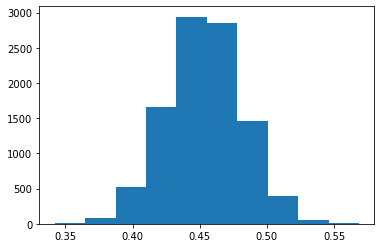

In [43]:
plt.hist(fl)